In [2]:
%matplotlib notebook
# starter code
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance
from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time

gtype = 'balanced-tree'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.6, 1.0

gvs = get_gvs(g, p, N2)

def gen_nontrivial_cascade(g, p, q, source=None):
    while True:
        source, c = simulate_cascade(g, p, source=source)
        obs_nodes = observe_cascade(c, source, q, method='uniform')
        cascade_size = np.sum(c != -1)

        if cascade_size >= 5:  # avoid small cascade
            break

    return c, source, obs_nodes

In [22]:
from ic import sll_using_pairs

while True:
    c, source, obs_nodes = gen_nontrivial_cascade(g, p, q)
    result = sll_using_pairs(
        g, obs_nodes, c, o2src_time=get_o2src_time(obs_nodes, gvs),
        method='exact', precond_method='and', 
        source=source,
        eps=0.2, return_cascade=True, debug=False)
    sll_and, rs, pairs = result['sll'], result['rs'], result['pairs']

    result = sll_using_pairs(
        g, obs_nodes, c, o2src_time=get_o2src_time(obs_nodes, gvs),
        method='exact', precond_method=None, 
        source=source,
        eps=0.2, return_cascade=True, debug=False)
    sll_none, rs, pairs = result['sll'], result['rs'], result['pairs']

    if sll_and[source] < sll_none[source]:
        print('and', sll_and[source])
        print('none', sll_none[source])
        break

/home/cloud-user/code/source_finding/ic.py:511: RuntimeWarning: invalid value encountered in true_divide
  probas = (((dists1 - dists2) == (t1 - t2)) * mask).sum(axis=0) / counts


and 0.229273391885
none 0.998969770785


<IPython.core.display.Javascript object>


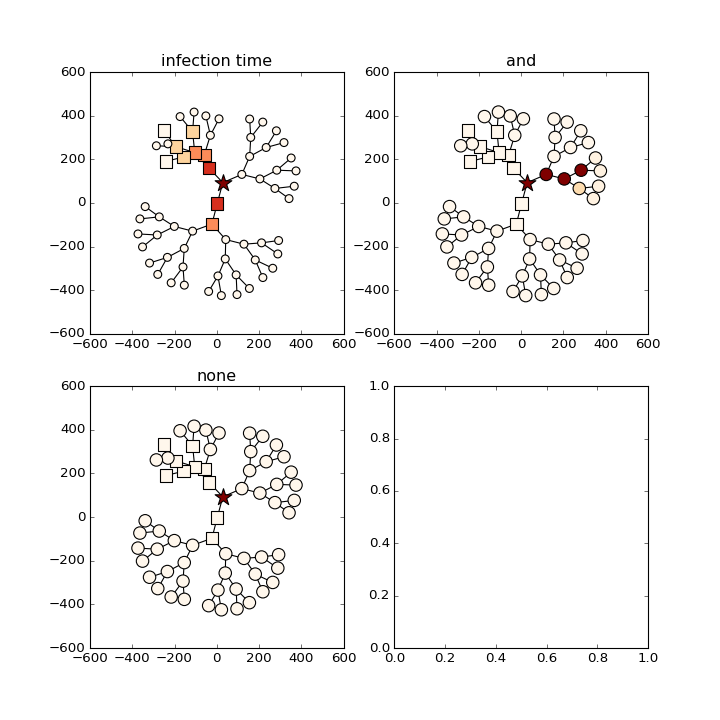

In [23]:
from matplotlib import pyplot as plt
from plot_utils import plot_snapshot
from utils import infeciton_time2weight
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(gnx, root=0)


fig, ax = plt.subplots(2, 2, figsize=(9, 9))
obs_nodes = list(obs_nodes)
plot_snapshot(gnx, pos,
              infeciton_time2weight({i: float(v) for i, v in enumerate(c)}),
              queried_nodes=obs_nodes,
              source_node=source,
              ax=ax[0, 0],
              max_node_size=500,
              with_labels=True)
ax[0, 0].set_title('infection time')
for i, scores, title in zip(range(1, 4),
                            [sll_and, sll_none],
                            ['and', 'none']):
    i, j = int(i / 2), int(i % 2)
    plot_snapshot(gnx, pos,
                  {i: float(v) for i, v in enumerate(scores)},
                  queried_nodes=obs_nodes,
                  source_node=source,
                  ax=ax[i, j],
                  max_node_size=500,
                  with_labels=True)
    ax[i, j].set_title(title)